In [1]:
import random
import csv

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys

from matplotlib.ticker import FormatStrFormatter
from scipy.signal import find_peaks
from tqdm import tqdm

from utils.eval.eval_utils import evaluate_peaks, compute_ROC
from utils.training.metrics import accuracy_for_segmenter, AUC_for_segmenter
from utils.training.data_loading import lines_to_line_generator, get_line_to_spectro_seg
from utils.training.keras_models import time_segmenter_model

2023-12-06 18:40:49.566764: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 18:40:49.785935: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 18:40:49.785980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 18:40:49.787210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 18:40:49.915559: I tensorflow/core/platform/cpu_feature_g

In [11]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/spectrograms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/OHASISBIO_2020/spectrograms"
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/test/HYDROMOMAR_2013/spectrograms"
BATCH_SIZE = 64
CHECKPOINT = "/media/plerolland/LaBoite/PublicData/trainings/checkpoints_auc_acc/checkpoints_seg/all/cp-0023.ckpt"

SIZE = (128, 186)  # number of pixels in the spectrograms
CHANNELS = 1  # 1 means grayscale 3 RGB
DURATION_S = 100  # duration of the spectrograms in s
OBJECTIVE_CURVE_WIDTH = 10  # defines dispersion of objective function in s

ALLOWED_ERROR_S = 10  # tolerance when evaluating and time distance allowed between two peaks in the probabilities distribution
MIN_PROBA = 0.0005  # minimum value of the output of the segmenter model to record it
TIME_RES = DURATION_S / SIZE[1]
OUTPUT_FILES_SUFFIX = "TiSSNet_hyd2013"

data_loader = get_line_to_spectro_seg(size=SIZE, duration_s=DURATION_S, channels=CHANNELS, objective_curve_width=OBJECTIVE_CURVE_WIDTH)
model = time_segmenter_model
m = model()
m.load_weights(CHECKPOINT)
m.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.binary_crossentropy,
            metrics=[accuracy_for_segmenter, AUC_for_segmenter()])

In [12]:
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
print(len(lines), "files found")
generator = lines_to_line_generator(lines, repeat=False)
dataset =tf.data.Dataset.from_generator(lambda: map(tuple, generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))
dataset = dataset.map(data_loader).batch(batch_size=BATCH_SIZE)

20736 files found


In [4]:
history = m.evaluate(dataset)

generator = lines_to_line_generator(lines, repeat=False)
dataset =tf.data.Dataset.from_generator(lambda: map(tuple, generator), output_signature=tf.TensorSpec(shape=[None], dtype=tf.string))
dataset = dataset.map(data_loader).batch(batch_size=BATCH_SIZE)

2023-12-05 16:38:42.848723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-05 16:38:42.881779: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 16:38:43.214649: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-05 16:38:44.014710: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-05 16:38:47.279496: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were avail

     27/Unknown - 13s 165ms/step - loss: 0.0299 - accuracy_for_segmenter: 0.9491 - auc_for_segmenter: 0.8507

KeyboardInterrupt: 

In [13]:
detected_peaks = []
ground_truth_peaks = []

for images, y in tqdm(dataset, total=1+int(len(lines)/BATCH_SIZE)):
    predicted = m.predict(images, verbose=False)
    for i, p in enumerate(predicted):
        detected_peaks.append(find_peaks(p, height=MIN_PROBA, distance=ALLOWED_ERROR_S/TIME_RES))
        _y = y[i,:,0] if len(y.shape) == 3 else y[i, :]
        ground_truth_peaks.append(find_peaks(_y, height=MIN_PROBA, distance=ALLOWED_ERROR_S/TIME_RES))
        
detected_peaks = [[(d[0][i]*TIME_RES, d[1]["peak_heights"][i]) for i in range(len(d[0]))] for d in detected_peaks]
ground_truth_peaks = [d[0]*TIME_RES for d in ground_truth_peaks]

  6%|▌         | 20/325 [00:05<01:13,  4.18it/s]

100%|█████████▉| 324/325 [01:17<00:00,  4.21it/s]


In [14]:
i,j = 0,0
for idx in range(len(detected_peaks)):
    i+=len(detected_peaks[idx])
    j+=len(ground_truth_peaks[idx])
print(f"{i} peaks found out of {j}")

128715 peaks found out of 1371


In [15]:
TP, FP, TP_per_seg, TN_per_seg, FP_per_seg, FN_per_seg, P_per_seg, N_per_seg = evaluate_peaks(ground_truth_peaks, detected_peaks, ALLOWED_ERROR_S)

In [16]:
print(len(TP), FP)
print(len(TP_per_seg), TN_per_seg, len(FP_per_seg), FN_per_seg, P_per_seg, N_per_seg)

1287 127428
1200 0 19536 0 1200 19536


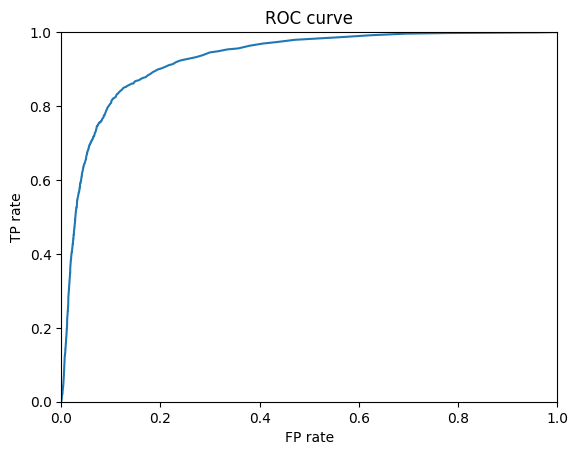

In [17]:
TPr, FPr = compute_ROC(TP_per_seg, P_per_seg, FP_per_seg, N_per_seg, thresh_delta=0.001)
plt.plot(FPr, TPr)
np.save(f"data/FPr_{OUTPUT_FILES_SUFFIX}.npy", FPr)
np.save(f"data/TPr_{OUTPUT_FILES_SUFFIX}.npy", TPr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.title("ROC curve")
plt.savefig(f"data/ROC_{OUTPUT_FILES_SUFFIX}.png")

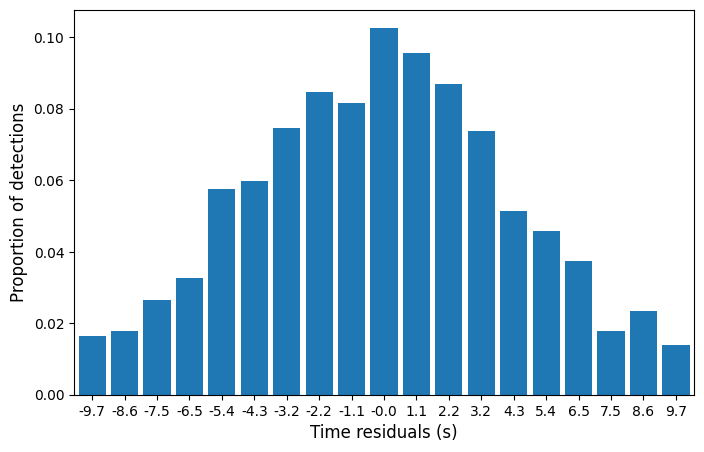

In [18]:
BAR_WIDTH = 0.9
step = 2*TIME_RES

extremum = step * np.round(ALLOWED_ERROR_S / step)
allowed_d = np.arange(-extremum, extremum+step, step)
TP_by_distance = {i : 0 for i in allowed_d}
for p in TP:
    thresh_s = allowed_d[np.argmin(np.abs(p[1] - allowed_d))]
    TP_by_distance[thresh_s] += 1
TP_by_distance = np.array(list(TP_by_distance.values())) / len(TP)

np.save(f"data/TP_by_distance_{OUTPUT_FILES_SUFFIX}.npy", TP_by_distance)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plt.bar(allowed_d, TP_by_distance, width=BAR_WIDTH, align='center')
plt.xticks(allowed_d)
plt.xlim(allowed_d[0]-0.5-(1-BAR_WIDTH), allowed_d[-1]+0.5+(1-BAR_WIDTH))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xlabel('Time residuals (s)', fontsize=12)
plt.ylabel('Proportion of detections', fontsize=12)
plt.savefig(f'data/histogram_{OUTPUT_FILES_SUFFIX}.png', bbox_inches='tight')